# Data Preperation

The cell below is the necessary steps to prepare data for modeling. Please see the EDA notebook for details.

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tools.eval_measures import rmse, aic
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from keras import models, layers, optimizers, regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, RepeatVector

tf.random.set_seed(3)
np.random.seed(3)

In [22]:
### Electricity Consumption Dataset ###

preview_e = pd.read_csv("Electric_Consumption_And_Cost__2010_-_April_2020_.csv")

preview_e['DATE'] = pd.to_datetime(preview_e['Service End Date'], format="%m/%d/%Y")

preview_e.set_index('DATE', inplace=True)

Manhattan = preview_e.loc[preview_e['Borough'] == 'MANHATTAN']

electric_manhattan = Manhattan.resample('MS').mean()

electric_manhattan = pd.DataFrame(electric_manhattan['Consumption (KWH)'])

### Weather Dataset ### 

preview_w = pd.read_csv('nyc_weather.csv')

preview_w['DATE'] = pd.to_datetime(preview_w['DATE'], format="%Y/%m")

keep = ['DATE', 'NAME', 'CDSD', 'EMNT', 'EMXT', 'HDSD', 'TAVG', 'TMAX', 'TMIN']

preview_w = preview_w[keep]

preview_w = preview_w.rename(columns={'CDSD': 'Cooling Degree Days Season',
                                      'EMNT': 'Extreme Minimum Temperature',
                                      'EMXT': 'Extreme Maximum Temperature',
                                      'HDSD': 'Heating Degree Days Season',
                                      'TAVG': 'Average Temperature',
                                      'TMAX': 'Maximum Temperature',
                                      'TMIN': 'Minimum Temperature'})

preview_w.set_index('DATE', inplace=True)

central_park = preview_w.loc[preview_w['NAME'] == 'NY CITY CENTRAL PARK, NY US']    

weather_central_park = central_park.resample('MS').mean()

weather_central_park = weather_central_park.loc[:'2021-02-01']

### Merge Datasets ###

manhattan_data = electric_manhattan.merge(weather_central_park, left_index=True, right_index=True)

### Train-Validation-Test Split ###
dataset = manhattan_data['2012-01-01':]
data = manhattan_data['2012-01-01':'2017-12-01'] # 2nd version of the train set
train = data[:'2016-12-01']
val = data['2017-01-01':]
test = manhattan_data['2019-01-01':]

print('manhattan_data shape: ', manhattan_data.shape)
print('data shape: ', data.shape)
print('train shape: ', train.shape)
print('val shape: ', val.shape)
print('test shape: ', test.shape)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


manhattan_data shape:  (134, 8)
data shape:  (72, 8)
train shape:  (60, 8)
val shape:  (12, 8)
test shape:  (26, 8)


In [23]:
# evaluating the forecasts
def adjust(val, length= 6): 
    return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

# convert input data into 3-D array as required for LSTM network
def split_sequence(sequence, n_steps):    
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Modeling

This time, I will train the data using LSTM(Long Short Term Memory) models. For the evaluation metrics, I will focus on RMSE(Root Mean Squared Error), which will show how much kWh are off, and MAPE(Mean Average Percentage Error), which will expresses the forecast error by how many percentage points the forecasts are off on average. 

## LSTM Model

Long Short-Term Memory (LSTM) recurrent neural networks can model problems with multiple input variables.

In [24]:
dataset_values = dataset.values

In [25]:
scaler = MinMaxScaler(feature_range=(0,1))

In [26]:
scaled_data = scaler.fit_transform(dataset_values)

In [27]:
train_data = scaled_data[:60]
train2_data = scaled_data[:72]
val_data = scaled_data[60:72]
test_data = scaled_data[-26:]
len(train_data), len(train2_data), len(val_data), len(test_data)

(60, 72, 12, 26)

In [28]:
features = 8
n_steps = 10

In [29]:
X_train, y_train = split_sequence(train_data, n_steps)
X_train2, y_train2 = split_sequence(train2_data, n_steps)
X_test, y_test = split_sequence(test_data, n_steps)
X_val, y_val = split_sequence(val_data, n_steps)

In [30]:
X_train.shape, y_train.shape

((50, 10, 8), (50, 8))

In [31]:
early = EarlyStopping(monitor='val_loss',patience=5)

#Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

In [32]:
test_data.shape

(26, 8)

In [33]:
y_test_re = scaler.inverse_transform(y_test)
y_test_re.shape

(16, 8)

In [34]:
model1 = Sequential()
model1.add(LSTM(128, activation='relu', return_sequences=False, input_shape=(n_steps, features)))
model1.add(RepeatVector(n_steps))
model1.add(LSTM(128, activation='relu', return_sequences=False))
model1.add(Dense(features))

model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', ])

In [35]:
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(X_val, y_val), callbacks=[early,reduce])

Epoch 1/50
1/1 [==============================] - 1s 816ms/step - loss: 0.3751 - mean_squared_error: 0.3751 - val_loss: 0.1825 - val_mean_squared_error: 0.1825
Epoch 2/50
1/1 [==============================] - 0s 53ms/step - loss: 0.3533 - mean_squared_error: 0.3533 - val_loss: 0.1642 - val_mean_squared_error: 0.1642
Epoch 3/50
1/1 [==============================] - 0s 37ms/step - loss: 0.3317 - mean_squared_error: 0.3317 - val_loss: 0.1455 - val_mean_squared_error: 0.1455
Epoch 4/50
1/1 [==============================] - 0s 36ms/step - loss: 0.3088 - mean_squared_error: 0.3088 - val_loss: 0.1259 - val_mean_squared_error: 0.1259
Epoch 5/50
1/1 [==============================] - 0s 38ms/step - loss: 0.2838 - mean_squared_error: 0.2838 - val_loss: 0.1045 - val_mean_squared_error: 0.1045
Epoch 6/50
1/1 [==============================] - 0s 36ms/step - loss: 0.2555 - mean_squared_error: 0.2555 - val_loss: 0.0818 - val_mean_squared_error: 0.0818
Epoch 7/50
1/1 [=============================

In [36]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               70144     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 202,760
Trainable params: 202,760
Non-trainable params: 0
_________________________________________________________________


In [37]:
# forecasting validation set
y_pred1 = model1.predict(X_val[])
y_pred1_inv = scaler.inverse_transform(y_pred1)
y_inv1 = scaler.inverse_transform(y_val)
rmse1 = np.sqrt(np.mean(((y_pred1_inv -y_inv1) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')

RMSE：2270.1503


In [45]:
# forecasting test set
y_pred2 = model1.predict(X_test)
y_pred2_inv = scaler.inverse_transform(y_pred2)
y_inv2 = scaler.inverse_transform(y_test)
rmse2 = np.sqrt(np.mean(((y_pred2_inv -y_inv2) ** 2)))
print(f'RMSE：{np.round(rmse2, 4)}')

RMSE：2698.0105


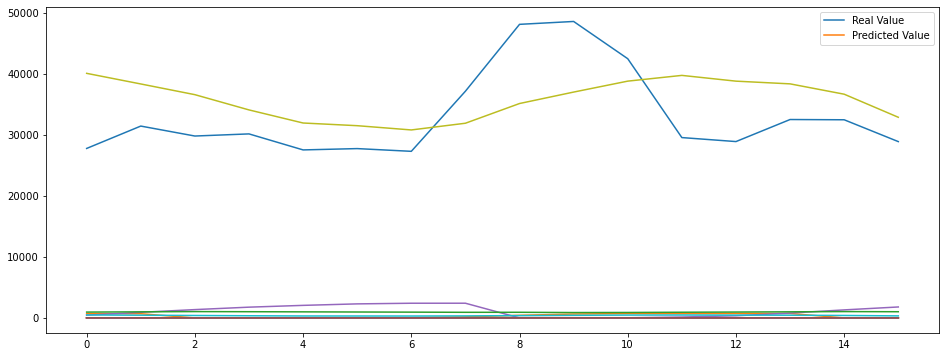

In [46]:
plt.figure(figsize=(16,6))
plt.plot(y_test_re[])
plt.plot(y_pred2_inv)
plt.legend(['Real Value','Predicted Value']);

In [111]:
y_pred2 = model2.predict(x_test)


In [112]:
y_pred_inv2 = scaler.inverse_transform(y_pred2)


In [114]:
y_test_inv = scaler.inverse_transform(y_test)

rmse2 = np.sqrt(np.mean(((y_pred_inv2 -y_test_inv) ** 2)))
print(f'RMSE：{np.round(rmse2, 4)}')


RMSE：1642.74


### "Question: Make a seperate notebook for modeling OR Add a table of content in one notebook?"

# XGB, RF,,,,

## Long Short Term Memory (LSTM) Model

In [490]:
data = manhattan_data['2012-01-01':'2017-12-01']
data.shape

(72, 8)

In [491]:
dataset = data.values

In [493]:
dataset.shape

(72, 8)

In [494]:
scaler = MinMaxScaler(feature_range=(0,1))

In [495]:
scaled_data = scaler.fit_transform(dataset)

In [496]:
train_data = scaled_data[:60, :]
train_data.shape

(60, 8)

In [497]:
def train_val(data):
    train_size = int(len(data) * 0.8)
    train = data[0:train_size]
    val= data[train_size:len(data)]
    return train, val

In [498]:
train_1, val_1 = train_val(train_data)

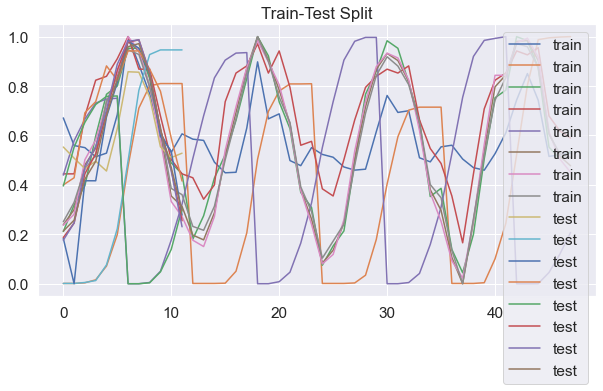

In [500]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_1, label='train')
ax.plot(val_1, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [501]:
def split_sequence(sequence, n_steps):
#convert input data into 3-D array as required for LSTM network
    
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [502]:
def prepare_training(data, n_steps):
    #data = to_dataset(data)
    train, val = train_val(data)
    x_train, y_train = split_sequence(train, n_steps)
    x_val, y_val = split_sequence(val, n_steps)
    features = 1
    return x_train, y_train, x_val, y_val, features

In [512]:
n_steps = 10

x_train, y_train, x_val, y_val, features = prepare_training(train_data,n_steps)

In [505]:
x_train.shape, y_train.shape

((38, 10, 8), (38, 8))

In [506]:
early = EarlyStopping(monitor='val_loss',patience=5)

#Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

In [508]:
test_data = scaled_data[60: , :]
test_data.shape

(12, 8)

In [509]:
x_test, y_test = split_sequence(test_data, n_steps)

In [510]:
y_test_re = scaler.inverse_transform(y_test)
y_test_re.shape

(2, 8)

In [516]:
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=False, input_shape=(n_steps, features)))
model.add(RepeatVector(n_steps))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dense(features))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])


In [517]:
history1 = model.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50


ValueError: in user code:

    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:224 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential_9: expected shape=(None, None, 1), found shape=[None, 10, 8]


In [357]:
scaler = MinMaxScaler()

In [358]:
scaled = scaler.fit_transform(data)
len(scaled)

72

In [451]:
X_train = scaled[:60, :]
y_train = scaled[:60, 0]
X_test = scaled[60:, :]
y_test =scaled[60:, 0]
X_train.shape, y_train.shape, X_test.shape, y_test.shape
#len(X_train), len(y_train), len(X_test)

((60, 8), (60,), (12, 8), (12,))

In [452]:
type(X_train), type(y_train), type(X_test),type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [453]:
# # reshape input to be 3D [samples, timesteps, features]
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [376]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


In [377]:
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)


Epoch 1/50
2/2 - 0s - loss: 0.5690 - val_loss: 0.5016
Epoch 2/50
2/2 - 0s - loss: 0.5359 - val_loss: 0.4714
Epoch 3/50
2/2 - 0s - loss: 0.5027 - val_loss: 0.4410
Epoch 4/50
2/2 - 0s - loss: 0.4694 - val_loss: 0.4105
Epoch 5/50
2/2 - 0s - loss: 0.4358 - val_loss: 0.3797
Epoch 6/50
2/2 - 0s - loss: 0.4020 - val_loss: 0.3486
Epoch 7/50
2/2 - 0s - loss: 0.3678 - val_loss: 0.3171
Epoch 8/50
2/2 - 0s - loss: 0.3331 - val_loss: 0.2851
Epoch 9/50
2/2 - 0s - loss: 0.2978 - val_loss: 0.2525
Epoch 10/50
2/2 - 0s - loss: 0.2619 - val_loss: 0.2192
Epoch 11/50
2/2 - 0s - loss: 0.2252 - val_loss: 0.1851
Epoch 12/50
2/2 - 0s - loss: 0.1896 - val_loss: 0.1544
Epoch 13/50
2/2 - 0s - loss: 0.1584 - val_loss: 0.1344
Epoch 14/50
2/2 - 0s - loss: 0.1330 - val_loss: 0.1211
Epoch 15/50
2/2 - 0s - loss: 0.1137 - val_loss: 0.1082
Epoch 16/50
2/2 - 0s - loss: 0.1032 - val_loss: 0.1029
Epoch 17/50
2/2 - 0s - loss: 0.0983 - val_loss: 0.1036
Epoch 18/50
2/2 - 0s - loss: 0.1004 - val_loss: 0.1088
Epoch 19/50
2/2 - 0

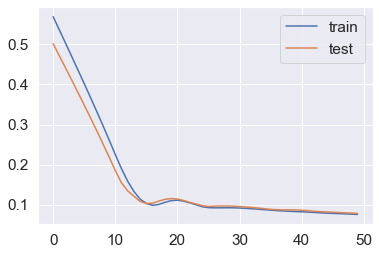

In [382]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [424]:
yhat.shape, test_X.shape, X_test.shape

((12, 1), (12, 8), (12, 8))

In [430]:
#predictions
    y_pred = model.predict(test_X_new)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_pred_inv = y_pred_inv.reshape(n_steps_out,1)
    y_pred_inv = y_pred_inv[:,0]
    print("y_pred :",y_pred.shape)
    print("y_pred_inv :",y_pred_inv.shape)
    
    return y_pred_inv , dataset_test_y , past_data
#start can be any point in the test data (1258)
start = 60
end = start + n_steps_in 
last = end + n_steps_out 
y_pred_inv , dataset_test_y , past_data = prep_data(x1_test_scaled , x2_test_scaled , y_test , start , end , last)

from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(X_test)
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
#inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat.reshape((len(y_test),1) ##
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


ValueError: in user code:

    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_4 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 8]


In [455]:
n_past = 59
n_future = 11
n_features = 8
train_generator = TimeseriesGenerator(X_train, y_train, length=n_past, batch_size=1)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_future, batch_size=1)

In [463]:
train_generator[0]

(array([[[6.71074975e-01, 1.16781502e-03, 2.11111111e-01, 4.44626192e-01,
          4.39549455e-01, 2.38709677e-01, 2.36772349e-01, 2.50783699e-01],
         [5.59296449e-01, 1.16781502e-03, 3.19444444e-01, 4.44626192e-01,
          5.78739767e-01, 3.00000000e-01, 2.81480245e-01, 3.29153605e-01],
         [5.50757484e-01, 3.73700806e-03, 3.97222222e-01, 6.78883390e-01,
          6.66279943e-01, 4.80645161e-01, 5.01826303e-01, 4.63949843e-01],
         [5.13738329e-01, 1.57655027e-02, 5.97222222e-01, 8.23649075e-01,
          7.31075433e-01, 5.48387097e-01, 5.81661831e-01, 5.20376176e-01],
         [5.28522392e-01, 7.14702791e-02, 7.66666667e-01, 8.39441695e-01,
          7.47480262e-01, 7.35483871e-01, 7.28559204e-01, 7.36677116e-01],
         [6.84050658e-01, 1.98762116e-01, 8.00000000e-01, 9.10508486e-01,
          7.50775555e-01, 8.41935484e-01, 8.53102628e-01, 8.18181818e-01],
         [1.00000000e+00, 4.75417494e-01, 9.52777778e-01, 1.00000000e+00,
          2.18364214e-05, 9.8064

In [464]:
model = Sequential()

In [465]:
model.add(LSTM(64, input_shape=(n_past, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

In [466]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [467]:
history = model.fit(train_generator, epochs=50, validation_data = test_generator)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.9762 - accuracy: 0.0000e+00 - val_loss: 0.4627 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 98ms/step - loss: 0.4757 - accuracy: 0.0000e+00 - val_loss: 0.3138 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 87ms/step - loss: 0.1997 - accuracy: 0.0000e+00 - val_loss: 0.2020 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 52ms/step - loss: 0.0602 - accuracy: 0.0000e+00 - val_loss: 0.1210 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 57ms/step - loss: 0.0308 - accuracy: 0.0000e+00 - val_loss: 0.0648 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 68ms/step - loss: 0.0198 - accuracy: 0.0000e+00 - val_loss: 0.0348 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 274ms/step - loss: 0.0428 - accuracy: 0.0000e+00 - val_loss: 0.0202

In [ ]:
model.summary()

In [468]:
model.evaluate_generator(test_generator, verbose=0)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.023190651088953018, 0.0]

In [470]:
predictions= model.predict_generator(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [472]:
X_test[:, 1:][n_future:]

array([[0.79586593, 0.15277778, 0.42883357, 0.31844744, 0.19677419,
        0.16332366, 0.2476489 ]])

In [473]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][n_future:])], axis=1)

In [475]:
rev_trans=scaler.inverse_transform(df_pred)
rev_trans


array([[-1.08556659,  0.59125453, -0.69444444, -0.36908517, -0.3631349 ,
        -0.60645161, -0.7124183 , -0.50470219]])

In [482]:
df_final = data[predictions.shape[0]*-1:]

In [483]:
df_final.count()

Consumption (KWH)              1
Cooling Degree Days Season     1
Extreme Minimum Temperature    1
Extreme Maximum Temperature    1
Heating Degree Days Season     1
Average Temperature            1
Maximum Temperature            1
Minimum Temperature            1
dtype: int64

In [484]:
df_final['consumption_pred'] = rev_trans[:,0]

<ipython-input-484-d85dec42765b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['consumption_pred'] = rev_trans[:,0]


In [485]:
df_final

,Consumption (KWH),Cooling Degree Days Season,Extreme Minimum Temperature,Extreme Maximum Temperature,Heating Degree Days Season,Average Temperature,Maximum Temperature,Minimum Temperature,consumption_pred
DATE,,,,,,,,,
2017-12-01,-0.532833,0.591255,-0.694444,-0.369085,-0.363135,-0.606452,-0.712418,-0.504702,-1.085567


In [447]:
# X, y = train_generator[0]
# print(f"given the array: {X.flatten()}")
# print(f"predict this y: {y}")

In [459]:
trainX = []
trainY = []

In [487]:
for i in range(n_past, len(X_train) - n_future +1):
    trainX.append(X_train[i - n_past:i, 0:scaled.shape[1]])
    trainY.append(y_train[i + n_future -1:i + n_future, 0])

In [461]:
#trainX, trainY = np.array(trainX), np.array(trainY)

In [488]:
trainX.shape, trainY.shape

((0,), (0,))

In [436]:
model = Sequential()

In [437]:
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

IndexError: tuple index out of range

In [367]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [368]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 12, 64)            18688     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 31,137
Trainable params: 31,137
Non-trainable params: 0
_________________________________________________________________


In [369]:
history = model.fit(train_generator, epochs=10, validation_data = test_generator)

Epoch 1/10
48/48 [==============================] - 1s 20ms/step - loss: 0.0818 - accuracy: 0.0000e+00 - val_loss: 0.3115 - val_accuracy: 0.0000e+00
Epoch 2/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0373 - accuracy: 0.0000e+00 - val_loss: 0.2903 - val_accuracy: 0.0000e+00
Epoch 3/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0233 - accuracy: 0.0000e+00 - val_loss: 0.2866 - val_accuracy: 0.0000e+00
Epoch 4/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0255 - accuracy: 0.0000e+00 - val_loss: 0.2822 - val_accuracy: 0.0000e+00
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0213 - accuracy: 0.0000e+00 - val_loss: 0.2768 - val_accuracy: 0.0000e+00
Epoch 6/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0191 - accuracy: 0.0000e+00 - val_loss: 0.2704 - val_accuracy: 0.0000e+00
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0124 - accuracy: 0.0000e+00 - v

In [352]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [353]:
scaled_train.shape

(60, 8)

In [371]:
n_input = 60
n_features = 8
train_gen = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
#test_gen = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

TypeError: object of type 'numpy.float64' has no len()

## LSTM Model

Long Short-Term Memory (LSTM) recurrent neural networks can model problems with multiple input variables.

In [437]:
dataset = manhattan_data['2012-01-01':]
trainset = dataset[:'2016-12-01']
trainset2 = dataset[:'2017-12-01']
valset = data['2017-01-01':'2017-12-01']
testset = manhattan_data['2019-01-01':]

print('dataset shape: ', dataset.shape)
print('trainset shape: ', trainset.shape)
print('trainset2 shape: ', trainset2.shape)
print('valset shape: ', valset.shape)
print('testset shape: ', testset.shape)
dataset.iloc[0]

dataset shape:  (99, 8)
trainset shape:  (60, 8)
trainset2 shape:  (72, 8)
valset shape:  (12, 8)
testset shape:  (26, 8)


Consumption (KWH)              39768.191057
Cooling Degree Days Season         0.000000
Extreme Minimum Temperature      -10.600000
Extreme Maximum Temperature       16.700000
Heating Degree Days Season      1227.100000
Average Temperature                3.000000
Maximum Temperature                6.800000
Minimum Temperature               -0.900000
Name: 2012-01-01 00:00:00, dtype: float64

In [438]:
dataset = dataset.values

In [439]:
scaler = MinMaxScaler(feature_range=(0,1))

In [440]:
scaled_data = scaler.fit_transform(dataset)

In [441]:
train_data = scaled_data[:60]
train2_data = scaled_data[:72]
val_data = scaled_data[60:72]
test_data = scaled_data[-26:]
len(train_data), len(train2_data), len(val_data), len(test_data)

(60, 72, 12, 26)

In [442]:
def split_sequence(sequence, n_steps):
#convert input data into 3-D array as required for LSTM network
    
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [443]:
features = 8
n_steps = 10

In [445]:
x_train, y_train = split_sequence(train_data, n_steps)
x_train2, y_train2 = split_sequence(train2_data, n_steps)
x_test, y_test = split_sequence(test_data, n_steps)
x_val, y_val = split_sequence(val_data, n_steps)

In [446]:
x_train.shape, y_train.shape

((50, 10, 8), (50, 8))

In [447]:
early = EarlyStopping(monitor='val_loss',patience=5)

#Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

In [448]:
test_data.shape

(26, 8)

In [449]:
y_test_re = scaler.inverse_transform(y_test)
y_test_re.shape

(16, 8)

In [450]:
model1 = Sequential()
model1.add(LSTM(128, activation='relu', return_sequences=False, input_shape=(n_steps, features)))
model1.add(RepeatVector(n_steps))
model1.add(LSTM(128, activation='relu', return_sequences=False))
model1.add(Dense(features))

model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', ])


In [451]:
history1 = model1.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
1/1 [==============================] - 0s 433ms/step - loss: 0.3751 - mean_squared_error: 0.3751 - val_loss: 0.1825 - val_mean_squared_error: 0.1825
Epoch 2/50
1/1 [==============================] - 0s 97ms/step - loss: 0.3533 - mean_squared_error: 0.3533 - val_loss: 0.1642 - val_mean_squared_error: 0.1642
Epoch 3/50
1/1 [==============================] - 0s 73ms/step - loss: 0.3317 - mean_squared_error: 0.3317 - val_loss: 0.1455 - val_mean_squared_error: 0.1455
Epoch 4/50
1/1 [==============================] - 0s 48ms/step - loss: 0.3088 - mean_squared_error: 0.3088 - val_loss: 0.1259 - val_mean_squared_error: 0.1259
Epoch 5/50
1/1 [==============================] - 0s 34ms/step - loss: 0.2838 - mean_squared_error: 0.2838 - val_loss: 0.1045 - val_mean_squared_error: 0.1045
Epoch 6/50
1/1 [==============================] - 0s 41ms/step - loss: 0.2555 - mean_squared_error: 0.2555 - val_loss: 0.0818 - val_mean_squared_error: 0.0818
Epoch 7/50
1/1 [=============================

In [452]:
y_pred1 = model1.predict(x_test)


In [453]:
y_pred_inv1 = scaler.inverse_transform(y_pred1)


In [455]:
y_test_inv = scaler.inverse_transform(y_test)

rmse1 = np.sqrt(np.mean(((y_pred_inv1 -y_test_inv) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')


RMSE：3153.895


In [ ]:
# evaluating the forecasts
def adjust(val, length= 6): 
    return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [456]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy_test_lstm = forecast_accuracy(y_pred_inv1['Consumption (KWH)_pred'].values, y_test_inv['Consumption (KWH)'])
for k, v in accuracy_test_lstm.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [136]:
y_test_inv = scaler.inverse_transform(y_test)

rmse1 = np.sqrt(np.mean(((y_pred_inv1 -y_test_inv) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')


RMSE：4472.6194


In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaled = scaler.fit_transform(data)
len(scaled)

In [ ]:
X_train = scaled[:60, :]
y_train = scaled[:60, 0]
X_test = scaled[60:, :]
y_test =scaled[60:, 0]
X_train.shape, y_train.shape, X_test.shape, y_test.shape
#len(X_train), len(y_train), len(X_test)

In [ ]:
type(X_train), type(y_train), type(X_test),type(y_test)

In [ ]:
# # reshape input to be 3D [samples, timesteps, features]
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


In [ ]:
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)


In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
yhat.shape, test_X.shape, X_test.shape

In [ ]:
#predictions
    y_pred = model.predict(test_X_new)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_pred_inv = y_pred_inv.reshape(n_steps_out,1)
    y_pred_inv = y_pred_inv[:,0]
    print("y_pred :",y_pred.shape)
    print("y_pred_inv :",y_pred_inv.shape)
    
    return y_pred_inv , dataset_test_y , past_data
#start can be any point in the test data (1258)
start = 60
end = start + n_steps_in 
last = end + n_steps_out 
y_pred_inv , dataset_test_y , past_data = prep_data(x1_test_scaled , x2_test_scaled , y_test , start , end , last)

from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(X_test)
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
#inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat.reshape((len(y_test),1) ##
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


In [ ]:
n_past = 59
n_future = 11
n_features = 8
train_generator = TimeseriesGenerator(X_train, y_train, length=n_past, batch_size=1)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_future, batch_size=1)

In [ ]:
train_generator[0]

In [ ]:
model = Sequential()

In [ ]:
model.add(LSTM(64, input_shape=(n_past, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=50, validation_data = test_generator)

In [ ]:
model.summary()

In [ ]:
model.evaluate_generator(test_generator, verbose=0)

In [ ]:
predictions= model.predict_generator(test_generator)

In [ ]:
X_test[:, 1:][n_future:]

In [ ]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][n_future:])], axis=1)

In [ ]:
rev_trans=scaler.inverse_transform(df_pred)
rev_trans


In [ ]:
df_final = data[predictions.shape[0]*-1:]

In [ ]:
df_final.count()

In [ ]:
df_final['consumption_pred'] = rev_trans[:,0]

In [ ]:
df_final

In [ ]:
# X, y = train_generator[0]
# print(f"given the array: {X.flatten()}")
# print(f"predict this y: {y}")

In [ ]:
trainX = []
trainY = []

In [ ]:
for i in range(n_past, len(X_train) - n_future +1):
    trainX.append(X_train[i - n_past:i, 0:scaled.shape[1]])
    trainY.append(y_train[i + n_future -1:i + n_future, 0])

In [ ]:
#trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
trainX.shape, trainY.shape

In [ ]:
model = Sequential()

In [ ]:
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data = test_generator)

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train.shape

In [ ]:
n_input = 60
n_features = 8
train_gen = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
#test_gen = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)